### この章の内容
***
1　データを元にしてそのまま重回帰・SVR<br>
2　階層的モデルの構想を練る<br>
3　データの形状を元に二乗項・三乗項を作成（Rainは一次、Timeは二次、Dateは三次）<br>
4　3を用いた重回帰・Lassoを実施
***

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [21]:
df_k = pd.read_csv("train_kanagawa.csv")
df_y= pd.read_csv("train_yamanashi.csv")

In [22]:
df_k['_'] = np.abs(df_k['Solar1'] - df_k['Solar2']) / 2

In [23]:
df_k['_'].mean()

101.46497386859637

・平均的に101ほどSolar1と2でズレが生じる。これらはそれぞれ予測するのが吉。

In [24]:
df_k['Clowdy'] = df_k['Weather'].map(lambda x: 1 if x == 1 else 0)
df_k['Rainy'] = df_k['Weather'].map(lambda x: 1 if x == 2 else 0)
df_k['Snowy'] = df_k['Weather'].map(lambda x: 1 if x == 3 else 0)
df_y['Clowdy'] = df_y['Weather'].map(lambda x: 1 if x == 1 else 0)
df_y['Rainy'] = df_y['Weather'].map(lambda x: 1 if x == 2 else 0)
df_y['Snowy'] = df_y['Weather'].map(lambda x: 1 if x == 3 else 0)

In [25]:
df_S1 = df_k.ix[:,['Solar1', 'Date-No', 'Time', 'Zero-Time', 'Rain', 'Temp', 'Wave', 'Clowdy', 'Rainy', 'Snowy']]
df_S2 = df_k.ix[:,['Solar2', 'Date-No', 'Time', 'Zero-Time', 'Rain', 'Temp', 'Wave', 'Clowdy', 'Rainy', 'Snowy']]
df_S3 = df_k.ix[:,['Solar3', 'Date-No', 'Time', 'Zero-Time', 'Rain', 'Temp', 'Clowdy', 'Rainy', 'Snowy']]

In [8]:
df_S1.head()

,Solar1,Date-No,Time,Zero-Time,Rain,Temp,Wave,Clowdy,Rainy,Snowy
0,0.0,1,0.5,1,30.0,5,0.5,1,0,0
1,0.0,1,1.0,1,30.0,5,0.5,1,0,0
2,0.0,1,1.5,1,30.0,5,0.5,1,0,0
3,0.0,1,2.0,1,30.0,5,0.5,1,0,0
4,0.0,1,2.5,1,30.0,5,0.5,1,0,0


機械学習しよう。

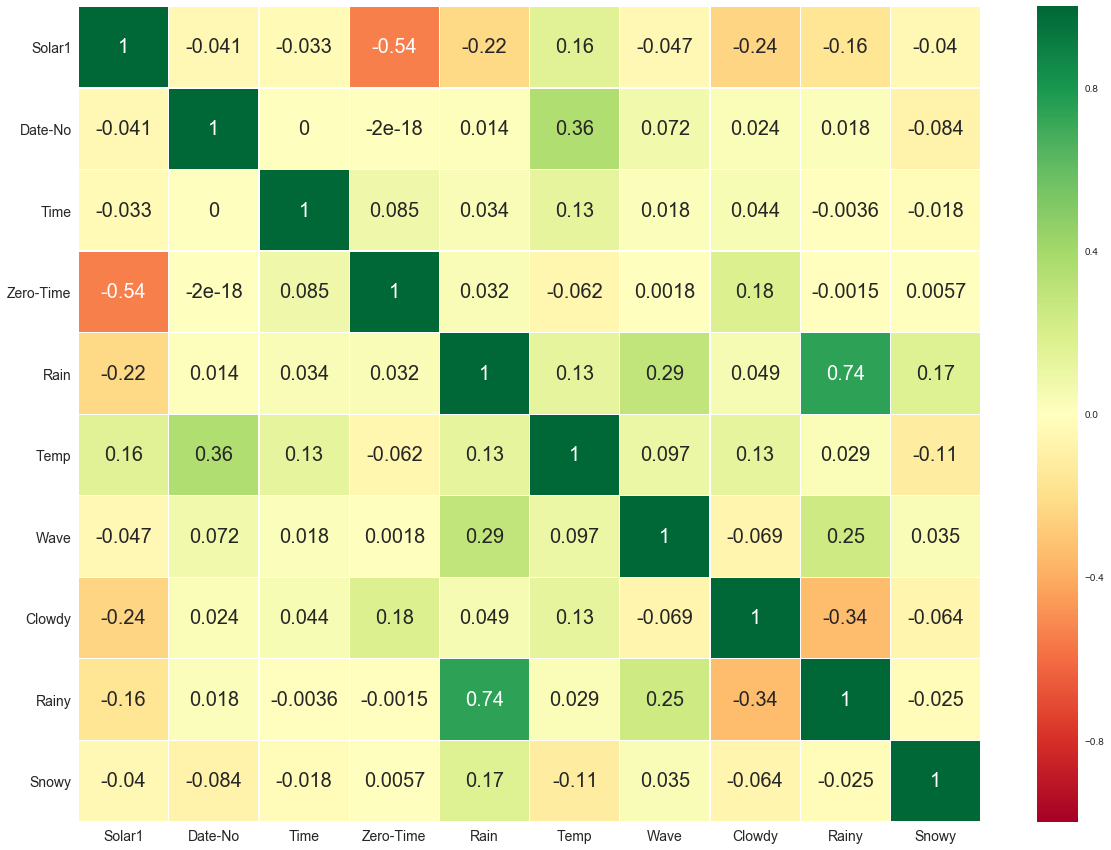

In [8]:
#相関をみる
sns.heatmap(df_S1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## モデルの予測

In [5]:
#importing all the required ML packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

In [288]:
df = df_S1[df_S1['Zero-Time'] == 0].drop('Zero-Time', axis=1)

In [289]:
#答えが0の時間は省いてしまう
df_zeros = df_S1[df_S1['Zero-Time'] == 1]

In [290]:
df.head()

,Solar1,Date-No,Time,Rain,Temp,Wave,Clowdy,Rainy,Snowy
9,0.0,1,5.0,30.0,4,0.5,1,0,0
10,0.0,1,5.5,30.0,4,0.5,1,0,0
11,0.0,1,6.0,30.0,4,0.5,1,0,0
12,0.0,1,6.5,30.0,4,0.5,1,0,0
13,0.0,1,7.0,30.0,4,0.5,1,0,0


In [291]:
train,test=train_test_split(df,test_size=0.3,random_state=0)
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=df[df.columns[1:]]
Y=df['Solar1']

まずは素直に重回帰

In [292]:
#重回帰分析
clf = linear_model.LinearRegression()
clf.fit(train_X, train_Y)
pre_Y = clf.predict(test_X.as_matrix())

# 偏回帰係数
print(pd.DataFrame({"Name":train_X.columns.values,"Coefficients":clf.coef_[0]}))
# 切片 (誤差)
print(clf.intercept_[0])

   Coefficients     Name
0     -1.430405  Date-No
1     -0.331967     Time
2     -4.119501     Rain
3     31.814148     Temp
4     -7.693888     Wave
5   -633.877896   Clowdy
6   -806.858139    Rainy
7   -725.039148    Snowy
1130.78063881


In [293]:
test_Y['Predicted'] = pre_Y
test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])
print("MSE:", test_Y['Error_abs'].mean())

MSE: 691.1227722607476


計算が早いLinearなSVRを実行する

In [15]:
#SVR：線形
linear =svm.SVR(kernel='linear',C=10)
linear.fit(train_X,train_Y)
prediction_linear = linear.predict(test_X)
print('MAE for linear SVR is ',metrics.mean_absolute_error(test_Y, prediction_linear))

MAE for linear SVR is  676.447542725


In [32]:
r = test_Y.reset_index(drop=True)
l_r = pd.DataFrame(prediction_linear)
l_df = pd.concat([l_r, r], axis=1)

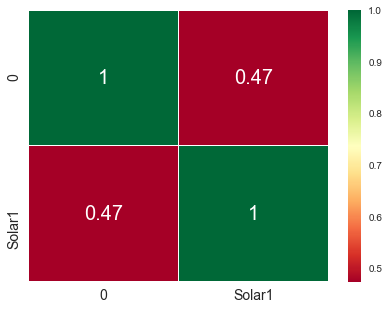

In [35]:
sns.heatmap(l_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

・前日、前々日との自己相関とか、もっと手動で変数を作って行った方がいいのかも。

rbfのSVRも実行してみる

In [36]:
#SVR：rbf
rbf =svm.SVR(kernel='rbf',C=10,gamma=0.1)
rbf.fit(train_X,train_Y) 
prediction_rbf = rbf.predict(test_X)
print('MAE for rbf SVR is ',metrics.mean_absolute_error(test_Y, prediction_rbf))

MAE for rbf SVR is  724.139273821


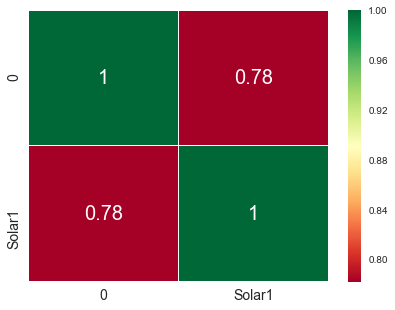

In [38]:
r = test_Y.reset_index(drop=True)
l_r = pd.DataFrame(prediction_rbf)
l_df = pd.concat([l_r, r], axis=1)
sns.heatmap(l_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

・相関係数は確かに上がった。一方でErrorは大きくなっている。

## もう少しデータにあった回帰を試みる

In [9]:
df_S1.head()

,Solar1,Date-No,Time,Zero-Time,Rain,Temp,Wave,Clowdy,Rainy,Snowy
0,0.0,1,0.5,1,30.0,5,0.5,1,0,0
1,0.0,1,1.0,1,30.0,5,0.5,1,0,0
2,0.0,1,1.5,1,30.0,5,0.5,1,0,0
3,0.0,1,2.0,1,30.0,5,0.5,1,0,0
4,0.0,1,2.5,1,30.0,5,0.5,1,0,0


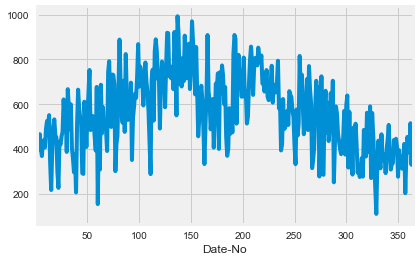

In [14]:
df_S1.groupby('Date-No')['Solar1'].mean().plot()

以下を検証する。
##### ＜太陽光発電は日射量に依存→雨だったらほぼ0になるはず＞

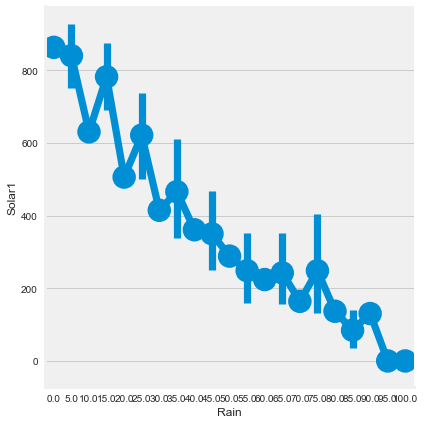

In [17]:
sns.factorplot('Rain', 'Solar1', data=df_S1, size = 6)

ほぼ線形の関係が得られた。仮説は正しそうである。

天気が違えばどの程度影響するかを見る。

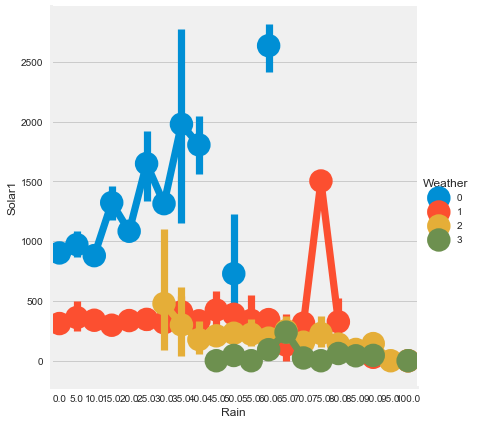

In [18]:
sns.factorplot('Rain', 'Solar1', data=df_k, hue='Weather' ,size = 6)

・晴れだと降水確率が上がるほど発電量が多い？？謎。<br>
・一方、曇り・雪だと降水確率にほぼ関係なく発電量が抑えられることがみて取れる。

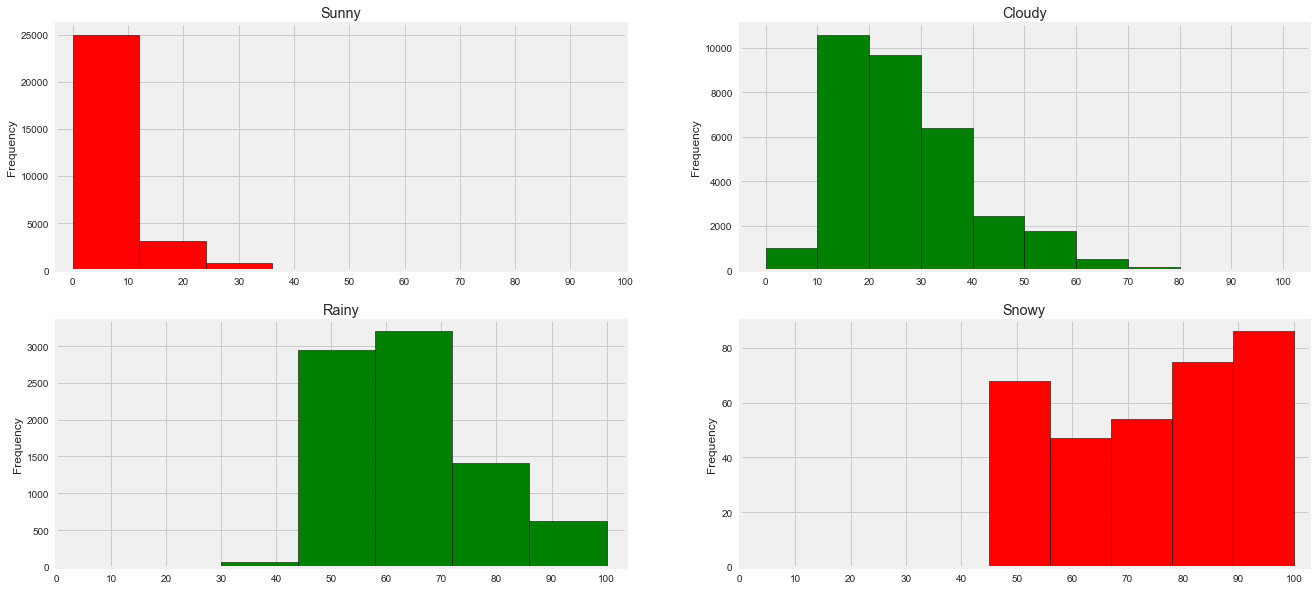

In [27]:
df = df_k
f,ax=plt.subplots(2,2,figsize=(20,10))
df[df['Weather']==0].Rain.plot.hist(ax=ax[0][0],bins=5,edgecolor='black',color='red')
ax[0][0].set_title('Sunny')
x=list(range(0,110,10))
ax[0][0].set_xticks(x)
df[df['Weather']==1].Rain.plot.hist(ax=ax[0][1],color='green',bins=10,edgecolor='black')
ax[0][1].set_title('Cloudy')
ax[0][1].set_xticks(x)
df[df['Weather']==2].Rain.plot.hist(ax=ax[1][0],color='green',bins=5,edgecolor='black')
ax[1][0].set_title('Rainy')
ax[1][0].set_xticks(x)
df[df['Weather']==3].Rain.plot.hist(ax=ax[1][1],color='red',bins=5,edgecolor='black')
ax[1][1].set_title('Snowy')
ax[1][1].set_xticks(x)
plt.show()

・晴れのとき降水確率30%以上は非常に稀：発電量との正の相関は嘘っぽい<br>

次に以下を検証する。
##### ＜季節性を除いたとき、日ごとの自己相関は０である＞

ここで、季節性とは晴れていた日の発電量によって傾向づけられていると仮定する。また、ここではまだ考慮していないが、年ごとの傾向も予測に加えていくことが、精度の向上に必要であると考えられる。

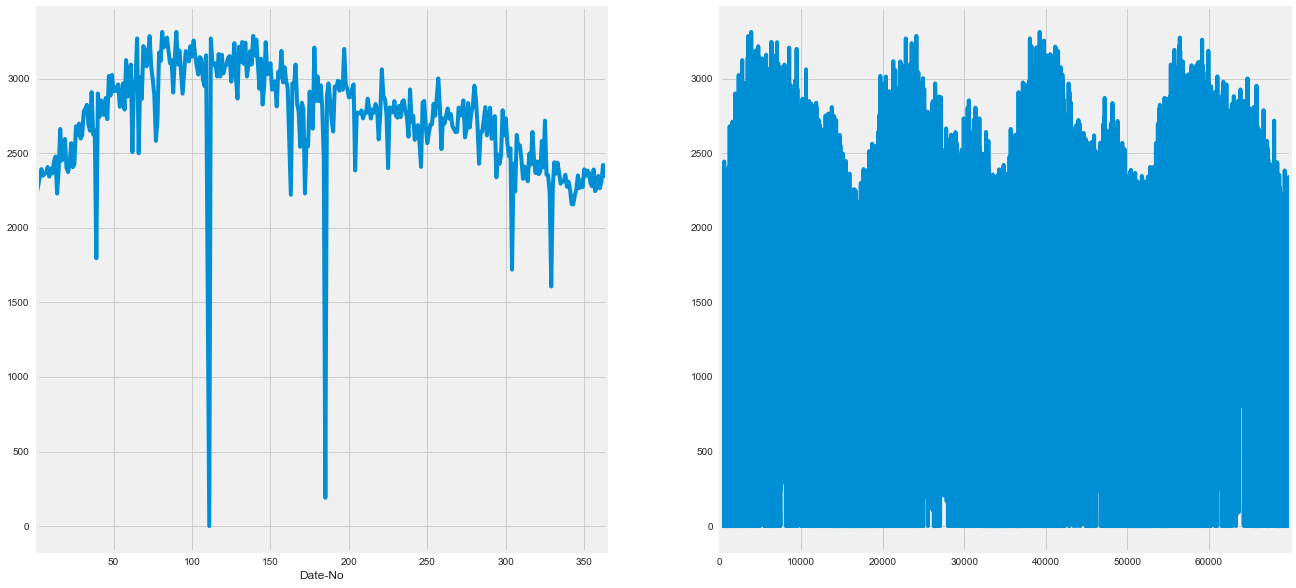

In [100]:
f,ax=plt.subplots(1,2,figsize=(20,10))
#晴れのみを抽出
tmp = df_k[df_k['Weather'] == 0]
tmp.groupby('Date-No')['Solar1'].max().plot(ax=ax[0])
tmp['Solar1'].plot(ax=ax[1])

In [102]:
#上図より、3次関数で近似する
from sklearn import linear_model

#外れ値の除去
d = pd.DataFrame(tmp.groupby('Date-No')['Solar1'].max())
d['diff'] = d['Solar1'].diff()
d = d[d['diff'] > -250]
d = d[d['diff'] < 250]
d = d.reset_index(drop=False)
d['x'] = d['Date-No']
d = d.ix[:,['Solar1', 'x']]

#乗数の作成
d['x2'] = d['x'] ** 2
d['x3'] = d['x'] ** 3

#重回帰分析
clf = linear_model.LinearRegression()
X = d.drop('Solar1', axis=1).as_matrix()
Y = d['Solar1']
clf.fit(X, Y)
# 偏回帰係数
print(pd.DataFrame({"Name":d.drop('Solar1', axis=1).columns,
                    "Coefficients":clf.coef_}))
# 切片 (誤差)
print(clf.intercept_)

   Coefficients Name
0     13.944825    x
1     -0.074067   x2
2      0.000099   x3
2310.08137083


In [103]:
#重回帰分析
model = pd.ols(y=Y, x=d.drop('Solar1', axis=1), intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <x2> + <x3> + <intercept>

Number of Observations:         306
Number of Degrees of Freedom:   4

R-squared:         0.8035
Adj R-squared:     0.8016

Rmse:            128.3201

F-stat (3, 302):   411.6558, p-value:     0.0000

Degrees of Freedom: model 3, resid 302

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x    13.9448     0.6852      20.35     0.0000    12.6018    15.2879
            x2    -0.0741     0.0043     -17.08     0.0000    -0.0826    -0.0656
            x3     0.0001     0.0000      12.71     0.0000     0.0001     0.0001
     intercept  2310.0814    29.1492      79.25     0.0000  2252.9489  2367.2139
---------------------------------End of Summary----------------

In [104]:
def fit(x):
     return 2310.0814 + 13.9448*x - 0.07407 * (x**2) + 0.0001* (x**3)

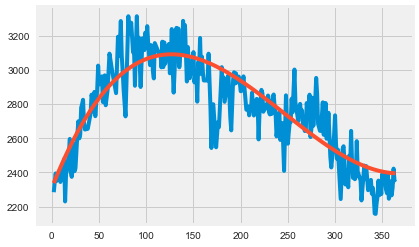

In [112]:
d['fit'] = fit(d['x'])
x = d['x'].values
plt.plot(x, d['Solar1'])
plt.plot(x, d['fit'])

残差の分析

In [113]:
d['residual'] = d['Solar1'] - d['fit'] 

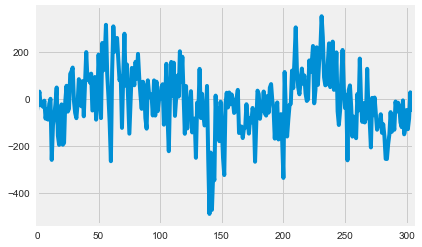

In [118]:
d['residual'].plot()

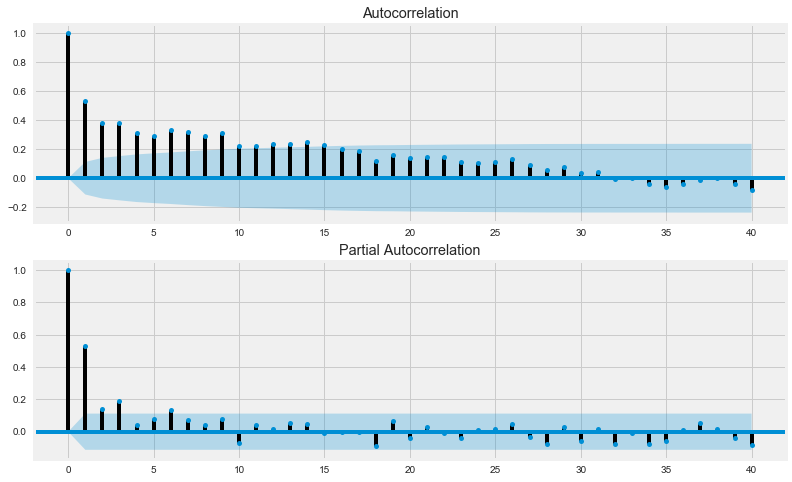

In [120]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(d['residual'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(d['residual'], lags=40, ax=ax2)

・自己相関は一次において大きく正の値を示した。しかし、この結果は天気が続きやすいことなど、他の要因の影響が含まれている可能性が高いと考えられる。よって、他の要因を含めて回帰した後の残差について、改めて調べることが必要である。<br>
・約半年を周期とした周期性が残っているように見える。これは取り出しておきたい（→フーリエ変換を用いた分析）

In [126]:
d.head()

,Solar1,x,x2,x3,fit,residual
0,2284.0,2,4,8,2337.67552,-53.67552
1,2345.0,3,9,27,2351.25187,-6.25187
2,2394.0,4,16,64,2364.68188,29.31812
3,2350.0,5,25,125,2377.96615,-27.96615
4,2362.0,6,36,216,2391.10528,-29.10528


In [135]:
d_r = d.ix[:,['x', 'residual']]

# 線形補間する
tmp = pd.DataFrame({'x':np.arange(1, 366)})
d_r = pd.merge(d_r, tmp, on='x', how='outer')
d_r = d_r.set_index('x')
d_r = d_r.sort_index()
d_r = d_r.interpolate()
d_r['residual'][1] = d_r['residual'][2]

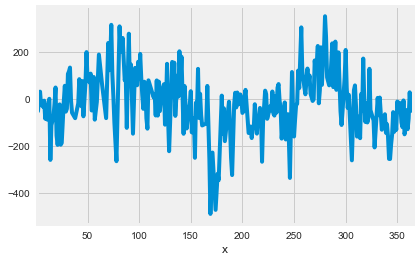

In [140]:
d_r['residual'].plot()

fftしてパワースペクトルを確認する。

In [172]:
from scipy import fftpack
sample_freq = fftpack.fftfreq(np.array(d_r['residual']).size, d=1)
y_fft = fftpack.fft(np.array(d_r['residual']))
pidxs = np.where(sample_freq > 0)
freqs, power = sample_freq[pidxs], np.abs(y_fft)[pidxs]
freq = freqs[power.argmax()]

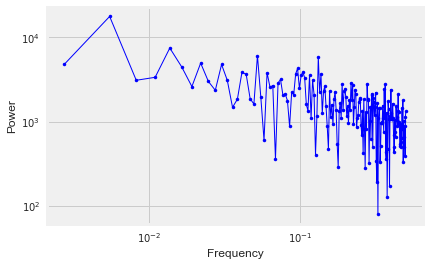

In [173]:
plt.loglog(freqs, power,'b.-',lw=1)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid(True)

確かに半年の周期が大きい。次に366/5=73.2日の周期が大きいが、これはあまり他を卓越していない。

そこでここでは、
\begin{eqnarray}
Residual = Asin{\frac{2\pi}{183}x } + Bcos{\frac{2\pi}{183}x } + error
\end{eqnarray}
として周期性を拾う。

※今回は3次関数での近似→半年周期での残差の回収としたが、この順序は恣意的である。これらを同時に回帰分析することで（年周期も含める）、より正しいモデルを構築できる可能性がある。：後に検証 <br>
※さらに言えば、元のSolarをFFTしてパワースペクトルを見ることで、より良い周期を得ることができる可能性もある。これも後に分析する。

In [174]:
d_r.head()

,residual
x,
1,-53.67552
2,-53.67552
3,-6.25187
4,29.31812
5,-27.96615


In [178]:
d_r = d_r.reset_index(drop=False)
d_r['sin'] = np.sin(2*np.pi*d_r['x']/183)
d_r['cos'] = np.cos(2*np.pi*d_r['x']/183)
d_r = d_r.set_index('x')

In [181]:
d_r.head()

,residual,sin,cos
x,,,
1,-53.67552,0.034328,0.999411
2,-53.67552,0.068615,0.997643
3,-6.25187,0.102821,0.994700
4,29.31812,0.136906,0.990584
5,-27.96615,0.170830,0.985301


In [184]:
#重回帰分析
clf = linear_model.LinearRegression()
X = d_r.drop('residual', axis=1).as_matrix()
Y = d_r['residual']
clf.fit(X, Y)

# 偏回帰係数
print(pd.DataFrame({"Name":d_r.drop('residual', axis=1).columns,"Coefficients":clf.coef_}))
# 切片 (誤差)
print(clf.intercept_)

   Coefficients Name
0     11.997810  sin
1    -96.114316  cos
-24.5409707828


In [185]:
clf.score(X, Y)

0.2881568717482732

In [186]:
def fit_sin(x):
     return -24.5409 + 11.9978 * np.sin(2*np.pi*d_r['x']/183) - 96.1143 * np.cos(2*np.pi*d_r['x']/183)

In [187]:
d_r = d_r.reset_index(drop=False)
d_r['fitted'] = fit_sin(d_r['x'])
d_r.head()

,x,residual,sin,cos,fitted
0,1,-53.67552,0.034328,0.999411,-120.186698
1,2,-53.67552,0.068615,0.997643,-119.605455
2,3,-6.25187,0.102821,0.994700,-118.912156
3,4,29.31812,0.136906,0.990584,-118.107620
4,5,-27.96615,0.170830,0.985301,-117.192793


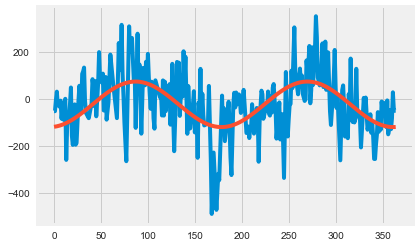

In [189]:
plt.plot(d_r['residual'])
plt.plot(d_r['fitted'])

・これで、そこそこトレンドを取ることができた。

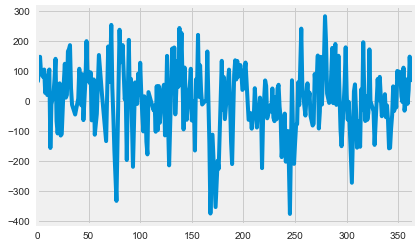

In [191]:
d_r['error'] = d_r['residual'] - d_r['fitted'] 
d_r['error'].plot()

以上でトレンド項の導出を一旦終える。次に、ここまでの回帰をまとめる。

### 細やかなモデルを考えてみる

今までの分析では、SolarのDateにより説明される部分fを以下のように定義してきた。<br>
<br>
\begin{eqnarray}
f(Date) = a_1(Date) + a_2{(Date)}^2 + a_3{(Date)}^3 + a_4sin{\frac{2\pi}{183}(Date) } + a_5cos{\frac{2\pi}{183}(Date) } + error
\end{eqnarray}

次に、Solarと多変数の関係は以下のように表されることが推測される（三層パーセプトロン的構造、mergeはSunnyの時のSolarの期待値に一致させる）。<br>
<br>
\begin{eqnarray}
merge = f(Date) * g(Time) * h(Rain)
\end{eqnarray}
<br>
<br>
\begin{eqnarray}
Solar =  [A_1merge + A_2Snowy + A_3Cloudy + A_4Rainy + error] (1 - ZeroTime)
\end{eqnarray}
<br>
このモデルを参考にしつつ予測してみる。ここで形状からgは二次関数、hは一次関数とし、各係数は初期値として推測から定めていく。<br>

#### Timeが二次近似で十分か確認する

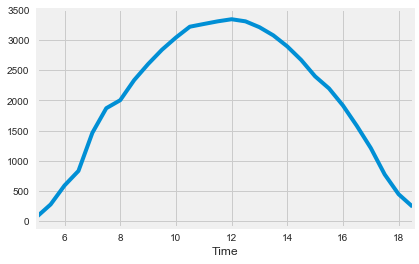

In [236]:
df_S1.groupby('Time').max().ix[5:18.5, 'Solar1'].plot()
y = df_S1.groupby('Time').max().ix[5:18.5, 'Solar1']

In [237]:
y = pd.DataFrame(y)
y = y.reset_index(drop=False)
y['2'] = y['Time'] ** 2

In [239]:
y.head()

,Time,Solar1,2
0,5.0,67.0,25.00
1,5.5,274.0,30.25
2,6.0,589.0,36.00
3,6.5,831.0,42.25
4,7.0,1464.0,49.00


In [240]:
model = pd.ols(y=y['Solar1'], x=y.ix[:,['Time', '2']], intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Time> + <2> + <intercept>

Number of Observations:         28
Number of Degrees of Freedom:   3

R-squared:         0.9882
Adj R-squared:     0.9873

Rmse:            124.5681

F-stat (2, 25):  1049.5942, p-value:     0.0000

Degrees of Freedom: model 2, resid 25

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          Time  1753.4694    38.4340      45.62     0.0000  1678.1387  1828.8002
             2   -73.9324     1.6166     -45.73     0.0000   -77.1009   -70.7639
     intercept -7153.0550   209.7186     -34.11     0.0000 -7564.1035 -6742.0065
---------------------------------End of Summary---------------------------------



In [241]:
y['predicted'] = -7153.05 + 1753.47 * y['Time'] - 73.9324 * (y['Time'] ** 2)

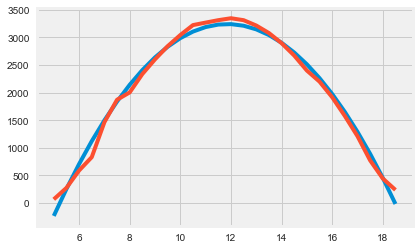

In [244]:
plt.plot(y['Time'], y['predicted'])
plt.plot(y['Time'], y['Solar1'])

・十分と思われる。

#### データを整える

In [11]:
#データを整える
df = df_S1[df_S1['Zero-Time'] == 0].drop(['Zero-Time'] , axis=1)
df['d2'] = df['Date-No'] ** 2
df['d3'] = df['Date-No'] ** 3
df['sind'] = np.sin(2*np.pi*df['Date-No']/183)
df['cosd'] = np.cos(2*np.pi*df['Date-No']/183)
df['t2'] = df['Time'] ** 2

In [296]:
df.head()

,Solar1,Date-No,Time,Rain,Temp,Wave,Clowdy,Rainy,Snowy,d2,d3,sind,cosd,t2
9,0.0,1,5.0,30.0,4,0.5,1,0,0,1,1,0.034328,0.999411,25.00
10,0.0,1,5.5,30.0,4,0.5,1,0,0,1,1,0.034328,0.999411,30.25
11,0.0,1,6.0,30.0,4,0.5,1,0,0,1,1,0.034328,0.999411,36.00
12,0.0,1,6.5,30.0,4,0.5,1,0,0,1,1,0.034328,0.999411,42.25
13,0.0,1,7.0,30.0,4,0.5,1,0,0,1,1,0.034328,0.999411,49.00


一度、これらの変数を元にしてモデルを生成してみる。

In [283]:
df.shape

(40768, 14)

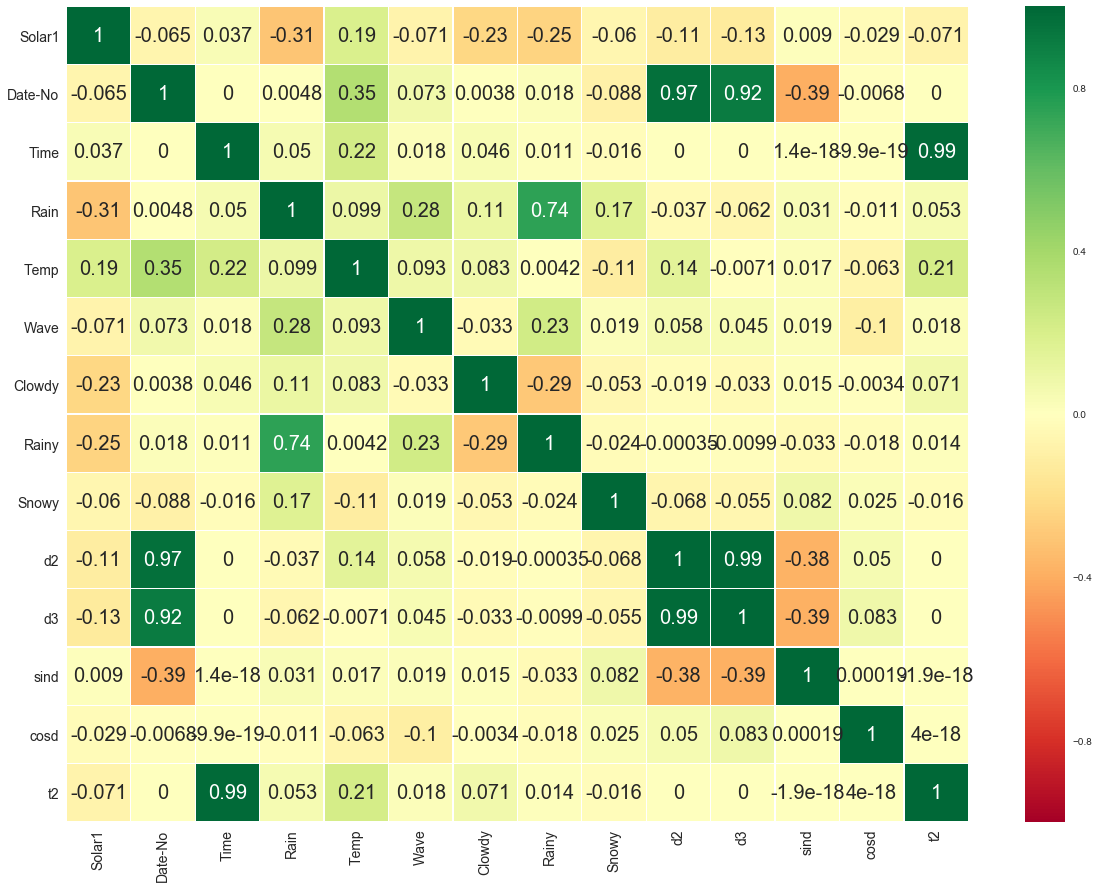

In [284]:
#相関をみる
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

・RainとRainyはまとめてしまっても（主成分分析）いいかも

##### まずは素直に重回帰

In [12]:
train,test=train_test_split(df,test_size=0.3,random_state=0)
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=df[df.columns[1:]]
Y=df['Solar1']

In [298]:
#重回帰分析
clf = linear_model.LinearRegression()
clf.fit(train_X, train_Y)
pre_Y = clf.predict(test_X.as_matrix())

# 偏回帰係数
print(pd.DataFrame({"Name":train_X.columns.values,"Coefficients":clf.coef_[0]}))
# 切片 (誤差)
print(clf.intercept_[0])

    Coefficients     Name
0      10.029524  Date-No
1    1047.203729     Time
2     -10.119447     Rain
3      20.172179     Temp
4      11.301622     Wave
5    -295.140343   Clowdy
6    -337.712326    Rainy
7    -223.075110    Snowy
8      -0.060703       d2
9       0.000092       d3
10     -3.978836     sind
11      2.085357     cosd
12    -44.410010       t2
-4728.90204001


In [322]:
test_Y['Predicted'] = pre_Y
test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])
print("MAE:", test_Y['Error_abs'].mean())

MAE: 446.48368439693587


In [323]:
#そう言えば、負の予測値は0にして良い
test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])
print("MAE:", test_Y['Error_abs'].mean())

MAE: 392.06485367528273


・かなり改善しているでゲス！！

In [321]:
model = pd.ols(y=train_Y['Solar1'], x=train_X, intercept=True)
print(model)


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <Date-No> + <Time> + <Rain> + <Temp> + <Wave> + <Clowdy> + <Rainy>
             + <Snowy> + <d2> + <d3> + <sind> + <cosd> + <t2> + <intercept>

Number of Observations:         28537
Number of Degrees of Freedom:   14

R-squared:         0.6774
Adj R-squared:     0.6772

Rmse:            546.1278

F-stat (13, 28523):  4606.8706, p-value:     0.0000

Degrees of Freedom: model 13, resid 28523

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
       Date-No    10.0295     0.3655      27.44     0.0000     9.3131    10.7460
          Time  1047.2037     5.4958     190.55     0.0000  1036.4319  1057.9755
          Rain   -10.1194     0.2942     -34.40     0.0000   -10.6961    -9.5428
          Temp    20.172

In [15]:
#上の表に従って、sindとcosdを抜く
df_2 = df.drop(['sind', 'cosd'], axis = 1)
train,test=train_test_split(df_2,test_size=0.3,random_state=0)
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=df[df.columns[1:]]
Y=df['Solar1']

In [325]:
#重回帰分析
clf = linear_model.LinearRegression()
clf.fit(train_X, train_Y)
pre_Y = clf.predict(test_X.as_matrix())

# 偏回帰係数
print(pd.DataFrame({"Name":train_X.columns.values,"Coefficients":clf.coef_[0]}))
# 切片 (誤差)
print(clf.intercept_[0])

    Coefficients     Name
0      10.119661  Date-No
1    1047.187562     Time
2     -10.126652     Rain
3      20.214694     Temp
4      10.950064     Wave
5    -295.026534   Clowdy
6    -336.962982    Rainy
7    -223.984058    Snowy
8      -0.061348       d2
9       0.000093       d3
10    -44.410069       t2
-4732.40439573


In [328]:
test_Y['Predicted'] = pre_Y
test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])
print("MAE:", test_Y['Error_abs'].mean())

MAE: 392.07263676514214


・重回帰分析ではsind, cosdは基本不要。

In [7]:
from sklearn import cross_validation, preprocessing, linear_model #機械学習用のライブラリを利用

In [13]:
clf_lasso = linear_model.Lasso(alpha=1.0)
clf_lasso.fit(train_X, train_Y)
 
print("\nLassoでの係数")
print(clf_lasso.intercept_) 
print(clf_lasso.coef_) 


Lassoでの係数
[-4684.70156888]
[  8.71302751e+00   1.04772249e+03  -1.09932349e+01   2.00016886e+01
   9.09095089e+00  -2.72424741e+02  -2.72158102e+02  -0.00000000e+00
  -5.17653043e-02   7.54380392e-05  -1.04575732e+01   0.00000000e+00
  -4.44259622e+01]


In [14]:
#sincos項を残して分析
pre_Y = clf_lasso.predict(test_X.as_matrix())
test_Y['Predicted'] = pre_Y
test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])
print("MAE:", test_Y['Error_abs'].mean())

MAE: 393.2069508403337


In [17]:
#sincos項を消して分析
clf_lasso = linear_model.Lasso(alpha=1.0)
clf_lasso.fit(train_X, train_Y)
pre_Y = clf_lasso.predict(test_X.as_matrix())
test_Y['Predicted'] = pre_Y
test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: 0 if x<0 else x)
test_Y['Error_abs'] = np.abs(test_Y['Solar1'] - test_Y['Predicted'])
print("MAE:", test_Y['Error_abs'].mean())

MAE: 393.1045891136108


### 今後やれること
***
##### 現在のMAE：280くらい
***
1　Dateをsin, cosの線形和で表す形を考えてみる<br>
2　今の分析でどこを上手く説明できていて、何が足りないのかを見つける（各変数がどのような状態のときに誤りが大きくなるか、どこで線型性が不十分であるか）<br>
3　残差に自己相関があるかを見る（あれば過去の値をデータとして加えると良い）<br>
4　Solar2, Solar3に対しても求めて、各変数にfitさせた形にしていく<br>
5　Timeをさらに高次で取り扱う<br>
6　傾向が変わる部分はそれぞれ分けて予測する<br>
7　相関の大きい部分には交差項を加えて分析する<br>
8　上述のかけ算項を含むモデルを考える<br>
9　8の手始めとして、様々にlogをとったモデルを考えてみる<br>
***

In [28]:
df_S1.to_csv('train_S1.csv', index = False,  header = True)
df_S2.to_csv('train_S2.csv', index = False,  header = True)
df_S3.to_csv('train_S3.csv', index = False,  header = True)